In [1]:
import matplotlib.pyplot as plt
import numpy as np
import optuna

from bayesian_optimization import jit_plus_server, plot_example_gpr

plt.rc("figure", figsize=(16, 10))

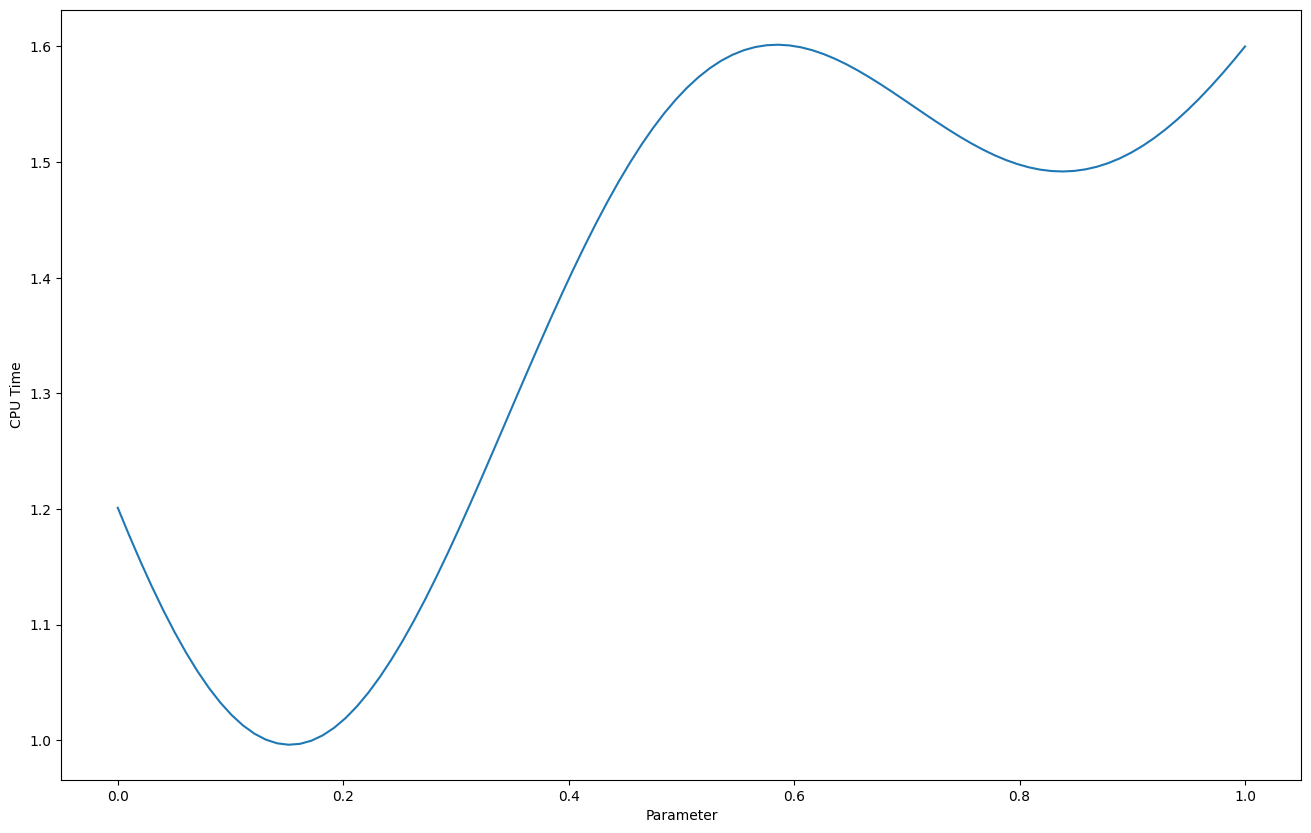

In [2]:
np.random.seed(20250127)


def jit_plus_server(parameters, is_noisy=False):
    x = np.array(parameters)
    d = len(x)
    x1 = x - 0.15 * np.ones(shape=(d,))
    x2 = x - 0.85 * np.ones(shape=(d,))
    cpu_time = 2 - np.exp(-10 * x1**2) - 0.5 * np.exp(-10 * x2**2)
    noise = 0.005 * np.random.normal()
    return cpu_time.mean() + is_noisy * noise


x = np.linspace(0, 1, 100)
y = [jit_plus_server([i]) for i in x]

plt.plot(x, y)
plt.xlabel("Parameter")
plt.ylabel("CPU Time");

In [3]:
# Optimal value (min).
i = np.argmin(y)
print("x={:.4f} | y={:.4f}".format(x[i], y[i]))

x=0.1515 | y=0.9962


Given an expensive black-box function, we can find the optimum value (minimizing) by trying all the different parameters.
By using bayesian optimization, we can reduce the number of trials before reaching the optimum value.

In [4]:
np.random.seed(20250127)


def objective(trial):
    x = trial.suggest_float("x", 0, 1)
    return jit_plus_server([x])


study = optuna.create_study()
study.optimize(objective, n_trials=16)

[I 2025-01-27 17:33:07,978] A new study created in memory with name: no-name-795d57fa-2ffb-46d9-adef-66b23bc601b5
[I 2025-01-27 17:33:07,980] Trial 0 finished with value: 1.5808752609783658 and parameters: {'x': 0.5247385565776095}. Best is trial 0 with value: 1.5808752609783658.
[I 2025-01-27 17:33:07,982] Trial 1 finished with value: 1.123186611629456 and parameters: {'x': 0.27336353198710606}. Best is trial 1 with value: 1.123186611629456.
[I 2025-01-27 17:33:07,984] Trial 2 finished with value: 1.403767904339469 and parameters: {'x': 0.4024233299036146}. Best is trial 1 with value: 1.123186611629456.
[I 2025-01-27 17:33:07,987] Trial 3 finished with value: 1.5537623547141344 and parameters: {'x': 0.9581787267693945}. Best is trial 1 with value: 1.123186611629456.
[I 2025-01-27 17:33:07,989] Trial 4 finished with value: 1.5016808617198545 and parameters: {'x': 0.7882766278291756}. Best is trial 1 with value: 1.123186611629456.
[I 2025-01-27 17:33:07,990] Trial 5 finished with value:

In [5]:
study.best_params

{'x': 0.1520723350245612}

In [6]:
jit_plus_server([study.best_params["x"]])

0.9962102128858974

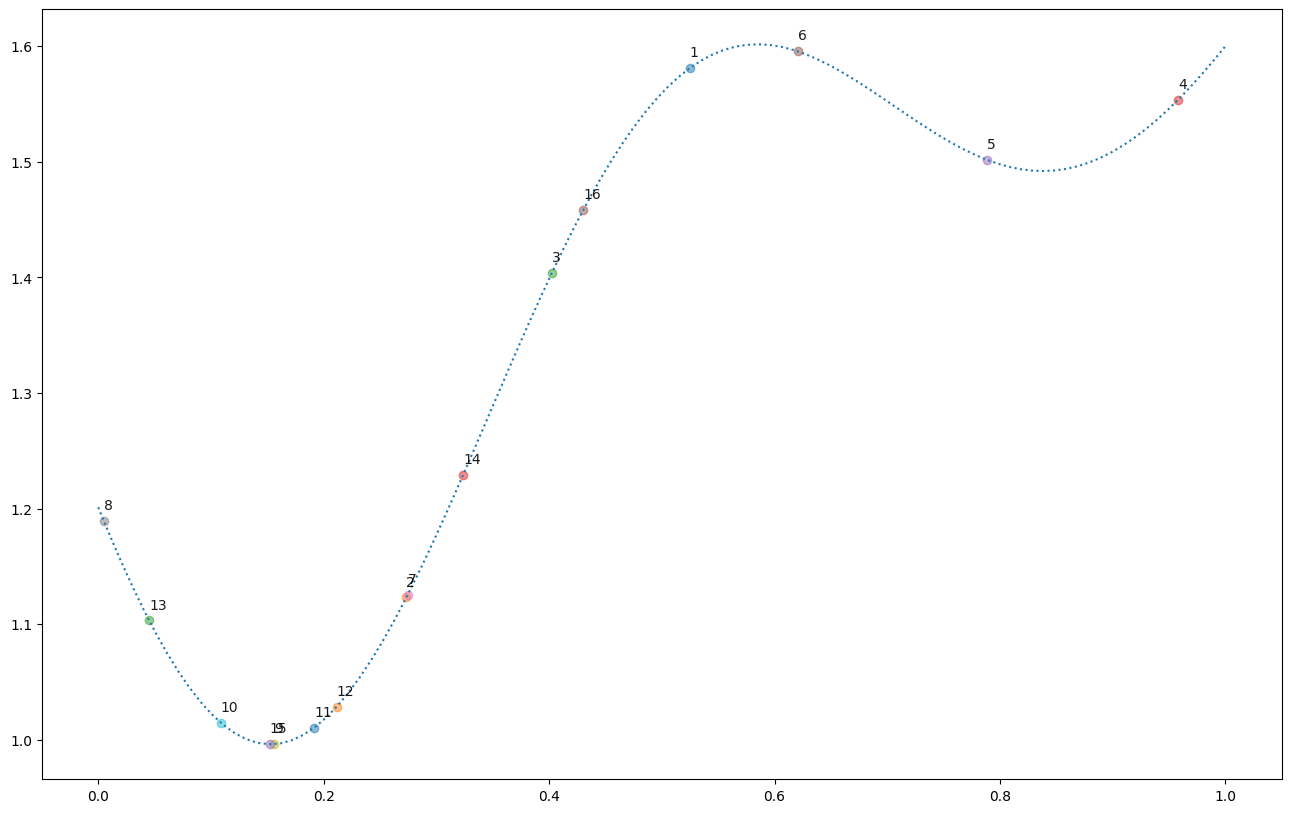

In [15]:
for t in study.trials:
    x_i = t.params["x"]
    y_i = t.values[0]
    text_i = t.number + 1
    plt.text(x_i, y_i + 0.01, text_i, alpha=0.9)
    plt.scatter(x_i, y_i, alpha=0.5)
plt.plot(x, y, linestyle="dotted");